In [200]:
# !pip install datasets
# !pip install morfeusz2

In [22]:
from datasets import Dataset, DatasetDict, load_dataset
import pandas as pd
from morfeusz2 import Morfeusz
from transformers import pipeline,AutoTokenizer
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
import spacy

In [201]:
# !python -m spacy download pl_core_news_sm

In [5]:
dataset = load_dataset("clarin-knext/fiqa-pl", 'corpus')

Generating corpus split: 0 examples [00:00, ? examples/s]

# Take 1 thousand random passages from the FIQA-PL corpus.

In [93]:
passages=pd.DataFrame(dataset['corpus']).sample(1000).reset_index(drop=True)

## Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence. E.g. the sentence:

In [127]:
nlp = spacy.load("pl_core_news_sm")

text='Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych oraz Maria Magdalena Nowacka.'

tokenizer = Tokenizer(nlp.vocab)

In [128]:
doc = nlp(text)

In [129]:
lemmatized_tokens = [token.lemma_ for token in doc]
tokenized_lemmatized_text = [token.text for token in nlp(" ".join(lemmatized_tokens))]

In [130]:
lemmatized_tokens

['wczoraj',
 'w',
 'Kraków',
 'mieć',
 'miejsce',
 'spotkanie',
 'prezydent',
 'Polska',
 'i',
 'Stany',
 'Zjednoczone',
 'oraz',
 'Maria',
 'Magdalena',
 'Nowacka',
 '.']

In [115]:
def make_proper_nouns(tokenized_lemmatized_text):
  proper_nouns = []
  current_proper_noun = []

  for token in tokenized_lemmatized_text:
      if token[0].isupper():
          current_proper_noun.append(token)
      elif current_proper_noun:
          proper_nouns.append(" ".join(current_proper_noun))
          current_proper_noun = []

  if current_proper_noun:
      proper_nouns.append(" ".join(current_proper_noun))
  return proper_nouns

In [131]:
make_proper_nouns(tokenized_lemmatized_text)


['Kraków', 'Polska', 'Stany Zjednoczone', 'Maria Magdalena Nowacka']

In [119]:
passages['lemmatized']=passages['text'].apply(lambda x: [token.lemma_ for token in nlp(x)])

In [120]:
passages['Capital_letter']=passages['lemmatized'].apply(lambda x: make_proper_nouns(x))

In [121]:
passages['Capital_letter'].head(10)

0     [USA, USA, X, ZWYKLE, Irańczyk, SSN, USCIS, SSN]
1                                             [Uważaj]
2                                        [Utrzymujemy]
3    [Wall Street, Wall Street, Wall Street, Wall S...
4    [X, Y USD, Dragon's Den, Kanada, Wielki Brytan...
5                                                   []
6                                     [Problemem, EEM]
7                                                   []
8                                              [Bezos]
9                   [Otrzeźwiający, Los Angeles Times]
Name: Capital_letter, dtype: object

## Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [122]:
from collections import Counter
passages['freq_list']=passages['Capital_letter'].apply(lambda word: Counter(word))

In [158]:
freq_list= Counter()
for counter in passages['freq_list']:
    freq_list.update(counter)

In [159]:
dict(sorted(freq_list.items(), key=lambda item: item[1],reverse=True)[:50])

{'USA': 110,
 'Twój': 59,
 'Ciebie': 46,
 'Stany Zjednoczone': 40,
 'IRS': 39,
 'IRA': 36,
 'Indie': 35,
 'LLC': 24,
 'ETF': 24,
 'Wielki Brytania': 20,
 'Twojej': 19,
 'X': 18,
 'Amazon': 18,
 'PKB': 17,
 'S&P': 17,
 'Bob': 17,
 'Google': 15,
 'Internet': 15,
 'Biorąc': 15,
 'Excel': 15,
 'Alicja': 15,
 'Kanada': 14,
 'USD': 13,
 'CD': 13,
 'HSA': 13,
 'W': 13,
 'A': 12,
 'Twojego': 12,
 'Twoich': 12,
 'AMT': 12,
 'Europa': 11,
 'Kalifornia': 11,
 'Microsoft': 11,
 'Uber': 11,
 'Jork': 10,
 'Załóżmy': 10,
 'UE': 10,
 'PM': 10,
 'Najlepsze': 10,
 'Twoją': 10,
 'Sprawdź': 10,
 'Roth IRA': 10,
 'Roth': 10,
 'FICO': 10,
 'NOK': 10,
 'Amerykanin': 9,
 'Apple': 9,
 'FMV': 9,
 'Kup': 9,
 'Facebook': 8}

## Apply the NER from SpaCy to identify the named entities in the same set of documents.

In [137]:
named_entities = [(ent.text, ent.label_) for ent in nlp(' '.join(lemmatized_tokens)).ents]

In [152]:
passages['NER']=passages['lemmatized'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(' '.join(x)).ents])

In [154]:
passages['NER'][0]

[('USA', 'placeName'),
 ('USA', 'placeName'),
 ('ZWYKLE', 'orgName'),
 ('Irańczyk', 'persName'),
 ('amerykański', 'placeName'),
 ('SSN', 'orgName'),
 ('USCIS', 'orgName'),
 ('SSN', 'orgName')]

In [155]:
passages['freq_list_ner']=passages['NER'].apply(lambda word: Counter(word))

## Display 50 most frequent Named Entities including their count and type.

In [160]:
freq_list_ner= Counter()
for counter in passages['freq_list_ner']:
    freq_list_ner.update(counter)
dict(sorted(freq_list_ner.items(), key=lambda item: item[1],reverse=True)[:50])

{('USA', 'placeName'): 110,
 ('amerykański', 'placeName'): 51,
 ('Stany Zjednoczone', 'placeName'): 40,
 ('IRA', 'orgName'): 37,
 ('Indie', 'placeName'): 35,
 ('ETF', 'orgName'): 23,
 ('LLC', 'orgName'): 19,
 ('Amazon', 'persName'): 16,
 ('Bob', 'persName'): 16,
 ('Wielki Brytania', 'placeName'): 15,
 ('Alicja', 'persName'): 15,
 ('Kanada', 'placeName'): 14,
 ('Google', 'orgName'): 13,
 ('S&P', 'orgName'): 13,
 ('Excel', 'persName'): 13,
 ('Europa', 'geogName'): 11,
 ('UE', 'orgName'): 11,
 ('brytyjski', 'placeName'): 11,
 ('1099', 'date'): 10,
 ('2008 rok', 'date'): 10,
 ('Roth IRA', 'orgName'): 10,
 ('Microsoft', 'orgName'): 10,
 ('kanadyjski', 'placeName'): 9,
 ('Kalifornia', 'placeName'): 9,
 ('Amerykanin', 'placeName'): 9,
 ('AMT', 'orgName'): 9,
 ('HSA', 'orgName'): 9,
 ('nowy Jork', 'placeName'): 8,
 ('Apple', 'orgName'): 8,
 ('musiałbyś', 'persName'): 8,
 ('FMV', 'orgName'): 7,
 ('Linkedin', 'persName'): 7,
 ('Nowy Jork', 'placeName'): 7,
 ('AGI', 'orgName'): 7,
 ('NOK', 'orgNa

## Plot the frequency (histogram) of the identified classes.

In [165]:
freq_list_classes= Counter()
for element in freq_list_ner.items():
  classes_freq={element[0][1]:element[1]}
  freq_list_classes.update(classes_freq)

In [169]:
freq_list_classes

Counter({'placeName': 640,
         'orgName': 682,
         'persName': 582,
         'date': 208,
         'geogName': 93,
         'time': 5})

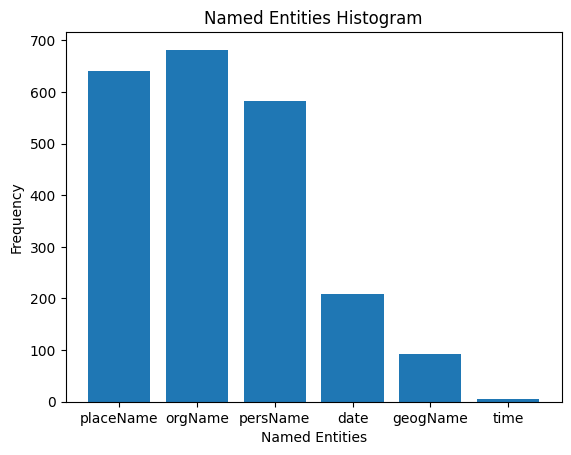

In [170]:
import matplotlib.pyplot as plt
labels, counts = zip(*freq_list_classes.items())
plt.bar(labels, counts)
plt.xlabel('Named Entities')
plt.ylabel('Frequency')
plt.title('Named Entities Histogram')
plt.show()

## Display 10 most frequent Named Entities for each identified type.

In [171]:
classes=list(freq_list_classes)

In [174]:
for class_example in classes:
  counter=0
  print(class_example)
  for element in dict(sorted(freq_list_ner.items(), key=lambda item: item[1],reverse=True)).items():
    if counter==10:
      break
    if element[0][1]==class_example:
      print(element)
      counter+=1


placeName
(('USA', 'placeName'), 110)
(('amerykański', 'placeName'), 51)
(('Stany Zjednoczone', 'placeName'), 40)
(('Indie', 'placeName'), 35)
(('Wielki Brytania', 'placeName'), 15)
(('Kanada', 'placeName'), 14)
(('brytyjski', 'placeName'), 11)
(('kanadyjski', 'placeName'), 9)
(('Kalifornia', 'placeName'), 9)
(('Amerykanin', 'placeName'), 9)
orgName
(('IRA', 'orgName'), 37)
(('ETF', 'orgName'), 23)
(('LLC', 'orgName'), 19)
(('Google', 'orgName'), 13)
(('S&P', 'orgName'), 13)
(('UE', 'orgName'), 11)
(('Roth IRA', 'orgName'), 10)
(('Microsoft', 'orgName'), 10)
(('AMT', 'orgName'), 9)
(('HSA', 'orgName'), 9)
persName
(('Amazon', 'persName'), 16)
(('Bob', 'persName'), 16)
(('Alicja', 'persName'), 15)
(('Excel', 'persName'), 13)
(('musiałbyś', 'persName'), 8)
(('Linkedin', 'persName'), 7)
(('Craftsman', 'persName'), 6)
(('Trump', 'persName'), 6)
(('Uber', 'persName'), 6)
(('Reddit', 'persName'), 5)
date
(('1099', 'date'), 10)
(('2008 rok', 'date'), 10)
(('2013 rok', 'date'), 6)
(('2017 rok'

## Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color. (For demo application Streamlit might be useful for displaying NER results).

In [199]:
# pip install spacy-streamlit streamlit

In [178]:
import streamlit as st
from spacy_streamlit import visualize_ner

2023-12-17 19:01:45.413 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [183]:
sentences=[]
number_of_sentences=0
for i in range(len(passages['text'])):
  entities=[]
  for entity in passages['NER'][i]:
    entities.append(entity)
  entities=list(set(entities))
  if len(entities)>1:
    sentences.append(passages['text'][i])
    number_of_sentences+=1
    if number_of_sentences>=5:
      break

In [184]:
sentences

['„Sankcje USA są zwykle bardzo zniuansowane i należy je sprawdzić samemu. Może się szerzyć, że „„ USA nałożyły sankcje na kraj X”” i może być powszechnie rozumiane, że oznacza to, że wszystkie środki pochodzące od kogokolwiek w tym kraju są zablokowane, że ZWYKLE tak nie jest (lub „wiele razy” nie jest prawdą, nie zamierzam zawracać sobie głowy określeniem tego) Wiele razy jest to wyczerpująca lista określonych osób i firm, które są zablokowane. listę tych organizacji. Ta błędna interpretacja może spływać na firmy. Można by pomyśleć, że duże firmy finansowe rozumieją przepisy, ale zazwyczaj reagują tylko na sposób zgłaszania spraw i nie mają jednolitego zrozumienia przepisów finansowych, którym podlegają. Prywatne firmy tworzą unikatowe i arbitralne zasady firmy w reakcji na ducha regulacji. Czy to możliwe, że wszyscy Irańczycy nie mogą wchodzić w interakcje z amerykańskim systemem finansowym? Jasne, to możliwe. Czy może być o wiele bardziej zniuansowane? Jasne. Czy ja Czy ma znaczeni

In [186]:
ner_labels = nlp.get_pipe("ner").labels

In [198]:
from spacy import displacy
from IPython.display import HTML
#used chatgpt to find right function to display entities.

for sentence in sentences:
  doc=nlp(sentence)
  options = {"ents": [ent.label_ for ent in doc.ents], "colors": {"ORG": "orange", "LOC": "green", "GPE": "blue"}}
  html_code=(displacy.render(doc, style="ent", options=options))
  display(HTML(html_code))

## Answer the following questions (2 points):

### Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?

Without a doubt, ner method did better job at identifying proper names. It leverages machine learning models and context to recognize entities. Capital letter method took unwanted words into account like 'W','A'.

### What are the drawbacks of the method based on capital letters?

Limited to basic capitalization rules and may not handle mixed-case or non-capitalized proper nouns well.
May result in false negatives for proper nouns with non-standard capitalization.

### What are the drawbacks of the method based on NER?

May not handle domain-specific or rare entities, requires annotated training data for optimal performance.

### Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

The best: placename. These entities often have clear contextual clues for the model to identify them accurately.

The worst: i think it's time. Sometimes it's hard to distinguish random number and actual time context.

### Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?

NER alone may not be sufficient for identifying different occurrences of the same entity, especially when expressed in different forms. However we can remedy that by doing postprocessing.

### Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?

NER can be highly beneficial in extracting information from medical records, identifying entities such as patient names, medical conditions, medications, and dates. It also applies to legal documents.